In [2]:
# import neccessary library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer 
from sklearn.feature_selection import RFE, SelectKBest, f_classif, VarianceThreshold
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LinearRegression
import os 
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Avoid data leakage to test data
# Impute missing data in train and test datasets using KNNImputer.
def impute_data(train, test):
    imputer = KNNImputer(n_neighbors=5)

    # Fit the imputer on the training data
    imputer.fit(train)

    # Transform both training and testing data
    train_imputed = imputer.transform(train)
    test_imputed = imputer.transform(test)

    return train_imputed, test_imputed

In [4]:
def load_feature_indexToLog_data(start_date, test_start_dates, end_date, rebal_period):
    # Load index data, impute missing values and return train and test datasets
    index_data_dir = os.path.join(os.getcwd(), 'data', 'feature_data', 'Price Level')
    result_train_df = pd.DataFrame()
    result_test_df = pd.DataFrame()
    
    index_data_name_file = {
        'OptionMetrics - DJX Interpolated Premium for the Option (CALL)': 'OptionMetrics - DJX Interpolated Premium for the Option (CALL).xlsx',
        'OptionMetrics - DJX Interpolated Premium for the Option (PUT)': 'OptionMetrics - DJX Interpolated Premium for the Option (PUT).xlsx',
        'OptionMetrics - DJX VegaKappa of the Option (CALL)': 'OptionMetrics - DJX VegaKappa of the Option (CALL).xlsx',
        'OptionMetrics - DJX VegaKappa of the Option (PUT)': 'OptionMetrics - DJX VegaKappa of the Option (PUT).xlsx',
        'OptionMetrics - RUT Interpolated Premium for the Option (CALL)': 'OptionMetrics - RUT Interpolated Premium for the Option (CALL).xlsx',
        'OptionMetrics - RUT Interpolated Premium for the Option (PUT)': 'OptionMetrics - RUT Interpolated Premium for the Option (PUT).xlsx',
        'OptionMetrics - RUT Strike Price, Currently Always Equal to Forward Price (CALL)': 'OptionMetrics - RUT Strike Price, Currently Always Equal to Forward Price (CALL).xlsx',
        'OptionMetrics - RUT Strike Price, Currently Always Equal to Forward Price (PUT)': 'OptionMetrics - RUT Strike Price, Currently Always Equal to Forward Price (PUT).xlsx',
        'OptionMetrics - RUT VegaKappa of the Option (CALL)': 'OptionMetrics - RUT VegaKappa of the Option (CALL).xlsx',
        'OptionMetrics - RUT VegaKappa of the Option (PUT)': 'OptionMetrics - RUT VegaKappa of the Option (PUT).xlsx',
        'OptionMetrics - SPX Interpolated Premium for the Option (CALL)': 'OptionMetrics - SPX Interpolated Premium for the Option (CALL).xlsx',
        'OptionMetrics - SPX Interpolated Premium for the Option (PUT)': 'OptionMetrics - SPX Interpolated Premium for the Option (PUT).xlsx',
        'OptionMetrics - SPX Strike Price, Currently Always Equal to Forward Price (PUT)': 'OptionMetrics - SPX Strike Price, Currently Always Equal to Forward Price (PUT).xlsx',
        'OptionMetrics - SPX VegaKappa of the Option (CALL)': 'OptionMetrics - SPX VegaKappa of the Option (CALL).xlsx'
        
    }
    
    for ind_name in index_data_name_file.keys():
        try:
            input = pd.read_excel(os.path.join(index_data_dir, index_data_name_file[ind_name]), index_col='Date')
            # Ensure that the index is a DatetimeIndex
            input.index = pd.to_datetime(input.index)
            input = input.sort_index(ascending=False)

            # Calculate monthly log return to enhance the stationarity of the data
            reb_index = input.iloc[:, 0].resample(rebal_period).first()
            # use log return 
            index_df = np.log(reb_index / reb_index.shift(1)).dropna()

             # Split the data into train and test based on the provided dates
            train_data = index_df.loc[start_date:test_start_dates]
            test_data = index_df.loc[test_start_dates:end_date]

            # Handle infinite values
            inf_indices_train = np.where(np.isinf(train_data))[0]
            inf_indices_test = np.where(np.isinf(test_data))[0]

            train_data[inf_indices_train] = np.nan
            test_data[inf_indices_test] = np.nan
            
            train_imputed, test_imputed = impute_data(train_data.values.reshape(-1, 1), test_data.values.reshape(-1, 1))

            # Convert back to Series
            train_imputed_series = pd.Series(train_imputed.flatten(), index=train_data.index)
            test_imputed_series = pd.Series(test_imputed.flatten(), index=test_data.index)

            # Rename the series for clarity
            train_imputed_series.rename(ind_name, inplace=True)
            test_imputed_series.rename(ind_name, inplace=True)

            result_train_df = pd.concat([result_train_df, train_imputed_series], axis=1)
            result_test_df = pd.concat([result_test_df, test_imputed_series], axis=1)
            
        except Exception as e:
            print(f"Error processing file: {index_data_name_file[ind_name]}")
            print(str(e))
            continue
    
    result_train_df.index = pd.to_datetime(result_train_df.index)
    result_test_df.index = pd.to_datetime(result_test_df.index)

    return result_train_df, result_test_df

In [5]:
# There are two versions of the "load_feature" function: 
# one for data calculated based on the rate of change and another for data based solely on price levels. 
# However, for the purposes of this project, I convert all the data to be based on the log base.
def load_feature_pctTolog_data(start_date, test_start_dates, end_date, rebal_period):
    # Load index data, impute missing values and return train and test datasets
    index_data_dir = os.path.join(os.getcwd(), 'data', 'feature_data', 'RateOfChange')
    result_train_df = pd.DataFrame()
    result_test_df = pd.DataFrame()
    
    index_data_name_file = {
        'CRSP Index File on the S&P 500 - Equal-Weighted Return-excl. dividends': 'CRSP Index File on the S&P 500 - Equal-Weighted Return-excl. dividends.xlsx',
        'CRSP Index File on the S&P 500 - Equal-Weighted Return-incl. dividends': 'CRSP Index File on the S&P 500 - Equal-Weighted Return-incl. dividends.xlsx',
        'CRSP Index File on the S&P 500 - Return on the S&P 500 Index': 'CRSP Index File on the S&P 500 - Return on the S&P 500 Index.xlsx',
        'CRSP Index File on the S&P 500 - Value-Weighted Return-excl. dividends': 'CRSP Index File on the S&P 500 - Value-Weighted Return-excl. dividends.xlsx',
        'CRSP Index File on the S&P 500 - Value-Weighted Return-incl. dividends': 'CRSP Index File on the S&P 500 - Value-Weighted Return-incl. dividends.xlsx',
        'US 1 Year Bond Returns': 'US 1 Year Bond Returns.xlsx',
        'US 2 Year Bond Returns': 'US 2 Year Bond Returns.xlsx',
        'US 5 Year Bond Returns': 'US 5 Year Bond Returns.xlsx',
        'US 7 Year Bond Returns': 'US 7 Year Bond Returns.xlsx',
        'US 10 Year Bond Returns': 'US 10 Year Bond Returns.xlsx',
        'US 20 Year Bond Returns': 'US 20 Year Bond Returns.xlsx',
        'US 30 Day Bill Returns': 'US 30 Day Bill Returns.xlsx',
        'US 30 Year Bond Returns': 'US 30 Year Bond Returns.xlsx',
        'US 90 Day Bill Returns': 'US 90 Day Bill Returns.xlsx',
        'US Rate of Change in Consumer Price Index': 'US Rate of Change in Consumer Price Index.xlsx'
    }
    
    for ind_name in index_data_name_file.keys():
        try:
            input = pd.read_excel(os.path.join(index_data_dir, index_data_name_file[ind_name]), index_col='Date')
             # Ensure that the index is a DatetimeIndex
            input.index = pd.to_datetime(input.index)
            input = input.sort_index(ascending=False)
            
             # Calculate monthly log return to enhance the stationarity of the data
            reb_index = input.iloc[:, 0].resample(rebal_period).first()
            # use log return 
            index_df = np.log(reb_index + 1 ).dropna()
             
            # Split the data into train and test based on the provided dates
            train_data = index_df.loc[start_date:test_start_dates]
            test_data = index_df.loc[test_start_dates:end_date]
            
            # Handle infinite values
            inf_indices_train = np.where(np.isinf(train_data))[0]
            inf_indices_test = np.where(np.isinf(test_data))[0]
            
            train_data[inf_indices_train] = np.nan
            test_data[inf_indices_test] = np.nan

            train_imputed, test_imputed = impute_data(train_data.values.reshape(-1, 1), test_data.values.reshape(-1, 1))

            # Convert back to Series
            train_imputed_series = pd.Series(train_imputed.flatten(), index=train_data.index)
            test_imputed_series = pd.Series(test_imputed.flatten(), index=test_data.index)

            # Rename the series for clarity
            train_imputed_series.rename(ind_name, inplace=True)
            test_imputed_series.rename(ind_name, inplace=True)

            result_train_df = pd.concat([result_train_df, train_imputed_series], axis=1)
            result_test_df = pd.concat([result_test_df, test_imputed_series], axis=1)
            
        except Exception as e:
            print(f"Error processing file: {index_data_name_file[ind_name]}")
            print(str(e))
            continue
    result_train_df.index = pd.to_datetime(result_train_df.index)
    result_test_df.index = pd.to_datetime(result_test_df.index)

    return result_train_df, result_test_df

In [6]:
# get target index data
def log_index_data_loading(start_date, test_start_dates, end_date, rebal_period):
    index_data_dir = os.path.join(os.getcwd(), 'data', 'index_data')
    result_train_df = pd.DataFrame()
    result_test_df = pd.DataFrame()
    
    index_data_name_file = {
        'CRSP Index File on the S&P 500 - Level of the S&P 500 Index':'CRSP Index File on the S&P 500 - Level of the S&P 500 Index.xlsx'
    }

    for ind_name in index_data_name_file.keys():
        try:
            input = pd.read_excel(os.path.join(index_data_dir, index_data_name_file[ind_name]), index_col='Date')
            # Ensure that the index is a DatetimeIndex
            input.index = pd.to_datetime(input.index)
            input = input.sort_index(ascending=False)
            
            reb_index = input.iloc[:, 0].resample(rebal_period).first()
            
            # Method 1: based on percentage change            
            # Calculate monthly percentage changes to enhance the stationarity of the data
            # Fill the first with 0
            # index_df = input.iloc[:, 0].resample(rebal_period).first().pct_change().fillna(0)
            
            # Method 2: use log return (Better for HMM model)
            index_df = np.log(reb_index / reb_index.shift(1)).dropna()
            # use cumulative return 
            #  index_df = (reb_index/reb_index.iloc[0])      
            
             # Split the data into train and test based on the provided dates
            train_data = index_df.loc[start_date:test_start_dates]
            test_data = index_df.loc[test_start_dates:end_date]
            
            # Handle infinite values
            inf_indices_train = np.where(np.isinf(train_data))[0]
            inf_indices_test = np.where(np.isinf(test_data))[0]

            train_data[inf_indices_train] = np.nan
            test_data[inf_indices_test] = np.nan

            train_imputed, test_imputed = impute_data(train_data.values.reshape(-1, 1), test_data.values.reshape(-1, 1))

            # Convert back to Series
            train_imputed_series = pd.Series(train_imputed.flatten(), index=train_data.index)
            test_imputed_series = pd.Series(test_imputed.flatten(), index=test_data.index)

            # Rename the series for clarity
            train_imputed_series.rename(ind_name, inplace=True)
            test_imputed_series.rename(ind_name, inplace=True)

            result_train_df = pd.concat([result_train_df, train_imputed_series], axis=1)
            result_test_df = pd.concat([result_test_df, test_imputed_series], axis=1)
            
        except Exception as e:
            print(f"Error processing file: {index_data_name_file[ind_name]}")
            print(str(e))
            continue

    result_train_df.index = pd.to_datetime(result_train_df.index)
    result_test_df.index = pd.to_datetime(result_test_df.index)

    return result_train_df, result_test_df

In [7]:
# Define general parameters
train_start_date = '1/1/2000'
test_start_date = '1/1/2017'
test_end_date = '31/12/2022'
rebal_period = '1M'
train_df1, test_df1 = load_feature_indexToLog_data(train_start_date, test_start_date, test_end_date, rebal_period)
train_df2, test_df2 = load_feature_pctTolog_data(train_start_date, test_start_date, test_end_date, rebal_period)

In [8]:
train_df = pd.concat([train_df1, train_df2], axis=1)
train_df.head()

,OptionMetrics - DJX Interpolated Premium for the Option (CALL),OptionMetrics - DJX Interpolated Premium for the Option (PUT),OptionMetrics - DJX VegaKappa of the Option (CALL),OptionMetrics - DJX VegaKappa of the Option (PUT),OptionMetrics - RUT Interpolated Premium for the Option (CALL),OptionMetrics - RUT Interpolated Premium for the Option (PUT),"OptionMetrics - RUT Strike Price, Currently Always Equal to Forward Price (CALL)","OptionMetrics - RUT Strike Price, Currently Always Equal to Forward Price (PUT)",OptionMetrics - RUT VegaKappa of the Option (CALL),OptionMetrics - RUT VegaKappa of the Option (PUT),...,US 1 Year Bond Returns,US 2 Year Bond Returns,US 5 Year Bond Returns,US 7 Year Bond Returns,US 10 Year Bond Returns,US 20 Year Bond Returns,US 30 Day Bill Returns,US 30 Year Bond Returns,US 90 Day Bill Returns,US Rate of Change in Consumer Price Index
2000-01-31,-0.919624,-0.884863,1.388777,1.387834,-0.690958,-0.813294,0.150854,0.150854,0.626227,0.626394,...,0.002473,-0.001418,-0.005603,-0.005065,-0.009845,0.016893,0.004334,0.004475,0.004330,0.002967
2000-02-29,0.702840,0.752566,-1.238654,-1.237836,0.856160,0.985337,0.036626,0.036626,-0.242077,-0.242282,...,0.005780,0.006819,0.009127,0.009460,0.013506,0.030217,0.004286,0.036116,0.004253,0.005907
2000-03-31,0.645908,0.788113,1.471032,1.467221,-0.122949,-0.144216,-0.026558,-0.026558,-0.232475,-0.232358,...,0.005324,0.006571,0.017481,0.026668,0.034162,0.034386,0.004367,0.046800,0.004782,0.008211
2000-04-30,-0.416241,-0.549502,-1.471250,-1.467386,-0.281516,-0.321276,-0.052678,-0.052678,0.422777,0.422680,...,0.003543,0.001495,-0.004283,-0.006740,-0.010077,-0.007859,0.004584,-0.013363,0.004929,0.000584
2000-05-31,0.449070,0.549389,0.011323,0.011331,0.207284,0.371138,0.015097,0.015097,-0.460046,-0.460368,...,0.004296,0.004913,0.004891,0.005819,0.001769,-0.004255,0.004771,-0.000867,0.006145,0.001167


In [9]:
test_df = pd.concat([test_df1, test_df2], axis=1)
test_df.head()

,OptionMetrics - DJX Interpolated Premium for the Option (CALL),OptionMetrics - DJX Interpolated Premium for the Option (PUT),OptionMetrics - DJX VegaKappa of the Option (CALL),OptionMetrics - DJX VegaKappa of the Option (PUT),OptionMetrics - RUT Interpolated Premium for the Option (CALL),OptionMetrics - RUT Interpolated Premium for the Option (PUT),"OptionMetrics - RUT Strike Price, Currently Always Equal to Forward Price (CALL)","OptionMetrics - RUT Strike Price, Currently Always Equal to Forward Price (PUT)",OptionMetrics - RUT VegaKappa of the Option (CALL),OptionMetrics - RUT VegaKappa of the Option (PUT),...,US 1 Year Bond Returns,US 2 Year Bond Returns,US 5 Year Bond Returns,US 7 Year Bond Returns,US 10 Year Bond Returns,US 20 Year Bond Returns,US 30 Day Bill Returns,US 30 Year Bond Returns,US 90 Day Bill Returns,US Rate of Change in Consumer Price Index
2017-01-31,-2.083783,-1.986946,0.098543,0.098635,0.567111,0.543162,0.275263,0.275263,-1.276086,-1.275581,...,0.001535,0.000848,0.002881,0.002365,0.002165,0.001947,0.000358,0.003432,0.000476,0.005811
2017-02-28,0.471424,0.388767,0.604598,0.605125,-2.404585,-2.403220,0.000172,0.000172,0.342014,0.341963,...,0.000055,0.000628,0.000809,0.003654,0.007396,0.011977,0.000364,0.014593,0.000352,0.003141
2017-03-31,1.088827,1.039138,0.126694,0.127132,1.044302,1.039032,0.005166,0.005166,-0.887066,-0.887043,...,0.000026,0.001441,0.003215,0.003133,0.002421,0.000421,0.000353,-0.000788,0.000384,0.000813
2017-04-30,-0.516687,-0.524743,-1.529784,-1.530752,0.605028,0.595962,0.014889,0.014889,1.794757,1.794604,...,0.000494,0.001316,0.007205,0.009514,0.011002,0.013270,0.000537,0.013844,0.000617,0.002962
2017-05-31,0.950358,0.935788,0.341950,0.341945,0.615883,0.623494,-0.012599,-0.012599,-0.151498,-0.151375,...,0.000730,0.001095,0.004690,0.007272,0.007825,0.014842,0.000614,0.019655,0.000588,0.000855


In [10]:
index_train_data, index_test_data = log_index_data_loading(train_start_date, test_start_date, test_end_date, rebal_period)



In [11]:
index_train_data.head()

,CRSP Index File on the S&P 500 - Level of the S&P 500 Index
2000-01-31,0.040315
2000-02-29,-0.032078
2000-03-31,-0.021583
2000-04-30,0.087941
2000-05-31,-0.025366


In [12]:
index_test_data.head()

,CRSP Index File on the S&P 500 - Level of the S&P 500 Index
2017-01-31,0.030010
2017-02-28,0.009574
2017-03-31,0.049806
2017-04-30,-0.015614
2017-05-31,0.012424


In [13]:
def plot_target_index(index_train_data):
    ax = index_train_data.plot()
    ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:.2f}".format(float(x))))
    plt.xlabel('Date')
    plt.ylabel('Log return on S&P')
    plt.title('Log return on S&P')
    plt.show()

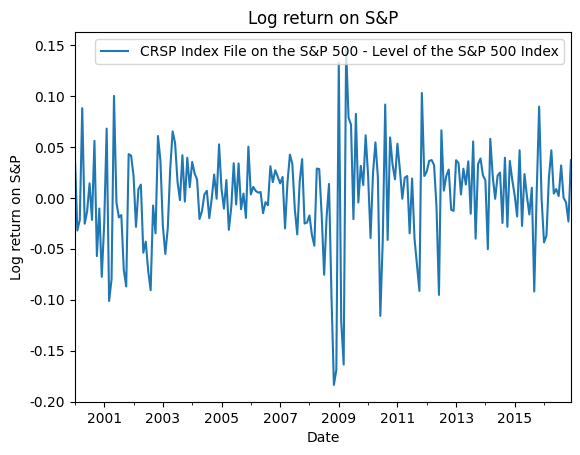

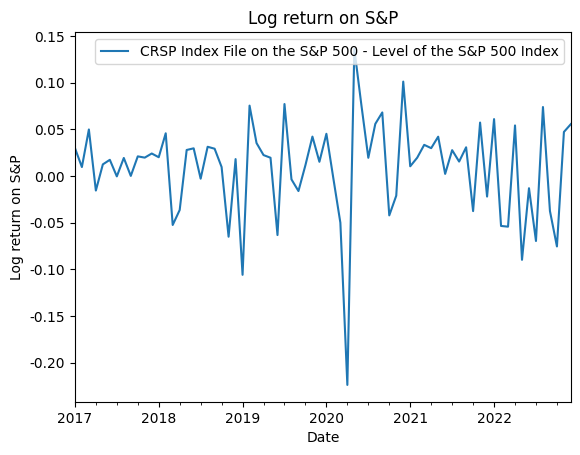

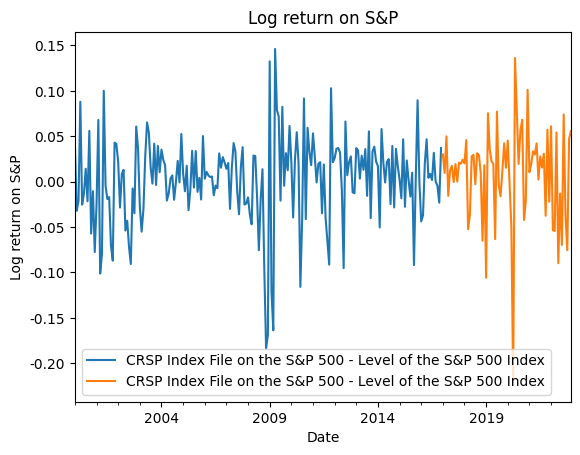

In [14]:
# Call the function with train and test data separately
plot_target_index(index_train_data)
plot_target_index(index_test_data)

# Concatenate train and test data and then plot
combined_data = pd.concat([index_train_data, index_test_data], axis=1)
plot_target_index(combined_data)

# Show the plots
plt.show()

In [15]:
def EMA_dataFrame(index_train_data, index_test_data, spans):
    result_train_df = pd.DataFrame()
    result_test_df = pd.DataFrame()
    
    for span in spans:
        try:
            train_EMA_column = index_train_data['CRSP Index File on the S&P 500 - Level of the S&P 500 Index'].ewm(span=span, adjust=False).mean()
            test_EMA_column = index_test_data['CRSP Index File on the S&P 500 - Level of the S&P 500 Index'].ewm(span=span, adjust=False).mean()

            # Handle Infinite values
            train_EMA_column.replace([np.inf, -np.inf], np.nan, inplace=True)
            test_EMA_column.replace([np.inf, -np.inf], np.nan, inplace=True)
            
            train_imputed, test_imputed = impute_data(train_EMA_column.values.reshape(-1, 1), test_EMA_column.values.reshape(-1, 1))

            # Convert back to Series
            train_imputed_series = pd.Series(train_imputed.flatten(), index=index_train_data.index, name=f'EMA {span}')
            test_imputed_series = pd.Series(test_imputed.flatten(), index=index_test_data.index, name=f'EMA {span}')
            
            result_train_df = pd.concat([result_train_df, train_imputed_series], axis=1)
            result_test_df = pd.concat([result_test_df, test_imputed_series], axis=1)

        except Exception as e:
            print(f"Error processing EMA span: {span}")
            print(str(e))
            continue

    return result_train_df, result_test_df


In [16]:
spans = [5, 10, 20, 50, 200]
train_EMA, test_EMA = EMA_dataFrame(index_train_data, index_test_data, spans)

In [17]:
train_EMA.head()

,EMA 5,EMA 10,EMA 20,EMA 50,EMA 200
2000-01-31 00:00:00,0.040315,0.040315,0.040315,0.040315,0.040315
2000-02-29 00:00:00,0.016184,0.027152,0.033420,0.037476,0.039594
2000-03-31 00:00:00,0.003595,0.018292,0.028182,0.035160,0.038986
2000-04-30 00:00:00,0.031710,0.030955,0.033873,0.037230,0.039473
2000-05-31 00:00:00,0.012685,0.020715,0.028231,0.034775,0.038828


In [18]:
test_EMA.head()

,EMA 5,EMA 10,EMA 20,EMA 50,EMA 200
2017-01-31 00:00:00,0.030010,0.030010,0.030010,0.030010,0.030010
2017-02-28 00:00:00,0.023198,0.026294,0.028063,0.029208,0.029806
2017-03-31 00:00:00,0.032067,0.030569,0.030134,0.030016,0.030005
2017-04-30 00:00:00,0.016173,0.022172,0.025777,0.028227,0.029551
2017-05-31 00:00:00,0.014924,0.020400,0.024505,0.027607,0.029381


In [19]:
train_df = pd.concat([train_df, train_EMA], axis=1)
test_df = pd.concat([test_df, test_EMA], axis=1)

In [20]:
train_df.head()

,OptionMetrics - DJX Interpolated Premium for the Option (CALL),OptionMetrics - DJX Interpolated Premium for the Option (PUT),OptionMetrics - DJX VegaKappa of the Option (CALL),OptionMetrics - DJX VegaKappa of the Option (PUT),OptionMetrics - RUT Interpolated Premium for the Option (CALL),OptionMetrics - RUT Interpolated Premium for the Option (PUT),"OptionMetrics - RUT Strike Price, Currently Always Equal to Forward Price (CALL)","OptionMetrics - RUT Strike Price, Currently Always Equal to Forward Price (PUT)",OptionMetrics - RUT VegaKappa of the Option (CALL),OptionMetrics - RUT VegaKappa of the Option (PUT),...,US 20 Year Bond Returns,US 30 Day Bill Returns,US 30 Year Bond Returns,US 90 Day Bill Returns,US Rate of Change in Consumer Price Index,EMA 5,EMA 10,EMA 20,EMA 50,EMA 200
2000-01-31 00:00:00,-0.919624,-0.884863,1.388777,1.387834,-0.690958,-0.813294,0.150854,0.150854,0.626227,0.626394,...,0.016893,0.004334,0.004475,0.004330,0.002967,0.040315,0.040315,0.040315,0.040315,0.040315
2000-02-29 00:00:00,0.702840,0.752566,-1.238654,-1.237836,0.856160,0.985337,0.036626,0.036626,-0.242077,-0.242282,...,0.030217,0.004286,0.036116,0.004253,0.005907,0.016184,0.027152,0.033420,0.037476,0.039594
2000-03-31 00:00:00,0.645908,0.788113,1.471032,1.467221,-0.122949,-0.144216,-0.026558,-0.026558,-0.232475,-0.232358,...,0.034386,0.004367,0.046800,0.004782,0.008211,0.003595,0.018292,0.028182,0.035160,0.038986
2000-04-30 00:00:00,-0.416241,-0.549502,-1.471250,-1.467386,-0.281516,-0.321276,-0.052678,-0.052678,0.422777,0.422680,...,-0.007859,0.004584,-0.013363,0.004929,0.000584,0.031710,0.030955,0.033873,0.037230,0.039473
2000-05-31 00:00:00,0.449070,0.549389,0.011323,0.011331,0.207284,0.371138,0.015097,0.015097,-0.460046,-0.460368,...,-0.004255,0.004771,-0.000867,0.006145,0.001167,0.012685,0.020715,0.028231,0.034775,0.038828


In [21]:
train_market_data = train_df.join(index_train_data, how = 'right')
test_market_data = test_df.join(index_test_data, how = 'right')

In [22]:
# Trying different method for feature selection
# 1. Adjust display options to show the full correlation matrix
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
train_market_data.corr()

,OptionMetrics - DJX Interpolated Premium for the Option (CALL),OptionMetrics - DJX Interpolated Premium for the Option (PUT),OptionMetrics - DJX VegaKappa of the Option (CALL),OptionMetrics - DJX VegaKappa of the Option (PUT),OptionMetrics - RUT Interpolated Premium for the Option (CALL),OptionMetrics - RUT Interpolated Premium for the Option (PUT),"OptionMetrics - RUT Strike Price, Currently Always Equal to Forward Price (CALL)","OptionMetrics - RUT Strike Price, Currently Always Equal to Forward Price (PUT)",OptionMetrics - RUT VegaKappa of the Option (CALL),OptionMetrics - RUT VegaKappa of the Option (PUT),OptionMetrics - SPX Interpolated Premium for the Option (CALL),OptionMetrics - SPX Interpolated Premium for the Option (PUT),"OptionMetrics - SPX Strike Price, Currently Always Equal to Forward Price (PUT)",OptionMetrics - SPX VegaKappa of the Option (CALL),CRSP Index File on the S&P 500 - Equal-Weighted Return-excl. dividends,CRSP Index File on the S&P 500 - Equal-Weighted Return-incl. dividends,CRSP Index File on the S&P 500 - Return on the S&P 500 Index,CRSP Index File on the S&P 500 - Value-Weighted Return-excl. dividends,CRSP Index File on the S&P 500 - Value-Weighted Return-incl. dividends,US 1 Year Bond Returns,US 2 Year Bond Returns,US 5 Year Bond Returns,US 7 Year Bond Returns,US 10 Year Bond Returns,US 20 Year Bond Returns,US 30 Day Bill Returns,US 30 Year Bond Returns,US 90 Day Bill Returns,US Rate of Change in Consumer Price Index,EMA 5,EMA 10,EMA 20,EMA 50,EMA 200,CRSP Index File on the S&P 500 - Level of the S&P 500 Index
OptionMetrics - DJX Interpolated Premium for the Option (CALL),1.000000,0.997461,0.137821,0.137801,0.008297,-0.001394,0.032492,0.032492,0.150520,0.150525,-0.078169,-0.088620,0.000232,1.151223e-01,-0.016092,-0.016224,-0.031494,-0.032626,-0.033137,0.077819,0.095256,0.124666,0.155940,0.166520,0.198890,0.003339,0.190301,0.005370,-0.112334,3.786431e-03,-0.000935,-0.001064,-0.001895,-0.010681,0.027400
OptionMetrics - DJX Interpolated Premium for the Option (PUT),0.997461,1.000000,0.143090,0.143059,0.021094,0.013613,0.032338,0.032338,0.152414,0.152416,-0.081122,-0.089548,0.002331,1.132628e-01,-0.023998,-0.024103,-0.038345,-0.039343,-0.039850,0.080964,0.101505,0.133536,0.165108,0.177289,0.209931,0.002879,0.203848,0.006514,-0.115557,3.881692e-03,0.000199,0.000318,-0.001124,-0.010574,0.027881
OptionMetrics - DJX VegaKappa of the Option (CALL),0.137821,0.143090,1.000000,1.000000,0.056316,0.052943,0.024715,0.024715,-0.035296,-0.035295,-0.060370,-0.056993,0.021627,1.399695e-01,-0.127239,-0.127265,-0.120381,-0.118972,-0.119591,-0.017353,-0.030129,-0.012077,-0.017076,-0.020187,-0.030652,0.016800,-0.028509,0.012662,0.080338,-4.719933e-03,0.007737,0.016065,0.019610,0.011198,-0.035519
OptionMetrics - DJX VegaKappa of the Option (PUT),0.137801,0.143059,1.000000,1.000000,0.056373,0.053008,0.024730,0.024730,-0.035352,-0.035351,-0.060392,-0.057018,0.021598,1.399451e-01,-0.127146,-0.127173,-0.120320,-0.118914,-0.119533,-0.017404,-0.030234,-0.012228,-0.017232,-0.020356,-0.030813,0.016808,-0.028676,0.012679,0.080335,-4.708252e-03,0.007726,0.016049,0.019601,0.011197,-0.035456
OptionMetrics - RUT Interpolated Premium for the Option (CALL),0.008297,0.021094,0.056316,0.056373,1.000000,0.996295,-0.080295,-0.080295,-0.095827,-0.095854,0.120074,0.119879,-0.125561,3.351777e-02,-0.044325,-0.044161,-0.053746,-0.054290,-0.054154,-0.007723,0.012534,0.020364,0.015026,-0.003666,-0.047912,0.014788,-0.061925,0.029261,0.040245,-4.155427e-02,-0.029487,-0.021020,-0.016294,-0.011636,-0.070970
OptionMetrics - RUT Interpolated Premium for the Option (PUT),-0.001394,0.013613,0.052943,0.053008,0.996295,1.000000,-0.075577,-0.075577,-0.096248,-0.096297,0.118851,0.120837,-0.120704,1.636648e-02,-0.048688,-0.048534,-0.058563,-0.059027,-0.058915,0.003543,0.026422,0.034771,0.027011,0.008884,-0.040840,0.015376,-0.056094,0.033970,0.043624,-3.949003e-02,-0.027351,-0.018857,-0.014539,-0.011240,-0.069657
"OptionMetrics - RUT Strike Price, Currently 

In [23]:
# 2. Recursive Feature Elimination (RFE) for Regression
model = LinearRegression()
rfe = RFE(model, n_features_to_select=10)
fit = rfe.fit(train_df, index_train_data.values.ravel())
selected_features_rfe = train_df.columns[fit.support_]
print('use RFE')
print("Num Features:", fit.n_features_)
print("Selected Features:", selected_features_rfe)
print("Feature Ranking:", fit.ranking_)

use RFE
Num Features: 10
Selected Features: Index(['OptionMetrics - RUT VegaKappa of the Option (CALL)',
       'CRSP Index File on the S&P 500 - Equal-Weighted Return-excl. dividends',
       'CRSP Index File on the S&P 500 - Equal-Weighted Return-incl. dividends',
       'CRSP Index File on the S&P 500 - Return on the S&P 500 Index',
       'CRSP Index File on the S&P 500 - Value-Weighted Return-excl. dividends',
       'CRSP Index File on the S&P 500 - Value-Weighted Return-incl. dividends',
       'EMA 5', 'EMA 10', 'EMA 20', 'EMA 50'],
      dtype='object')
Feature Ranking: [17 16 10  9 22 21 23 20  1  2 19 18 24 25  1  1  1  1  1  5  6  7  8 13
 15  3 14 11 12  1  1  1  1  4]


In [24]:
# 3. Feature Importance from RandomForest
# If it's regression:
forest = RandomForestRegressor(n_estimators=100)
# If it's classification:
# forest = RandomForestClassifier(n_estimators=100)

forest.fit(train_df, index_train_data.values.ravel())
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]
print("RandomForest: Feature ranking:")
for f in range(train_df.shape[1]):
    print("%d. Feature %s (%f)" % (f + 1, train_df.columns[indices[f]], importances[indices[f]]))

RandomForest: Feature ranking:
1. Feature EMA 5 (0.579404)
2. Feature EMA 50 (0.051275)
3. Feature EMA 10 (0.044420)
4. Feature EMA 20 (0.037222)
5. Feature US 7 Year Bond Returns (0.017328)
6. Feature OptionMetrics - SPX Strike Price, Currently Always Equal to Forward Price (PUT) (0.015181)
7. Feature CRSP Index File on the S&P 500 - Equal-Weighted Return-excl. dividends (0.014873)
8. Feature EMA 200 (0.013480)
9. Feature CRSP Index File on the S&P 500 - Equal-Weighted Return-incl. dividends (0.013388)
10. Feature US Rate of Change in Consumer Price Index (0.012280)
11. Feature CRSP Index File on the S&P 500 - Value-Weighted Return-incl. dividends (0.012111)
12. Feature US 10 Year Bond Returns (0.011597)
13. Feature OptionMetrics - DJX Interpolated Premium for the Option (CALL) (0.011118)
14. Feature OptionMetrics - RUT Strike Price, Currently Always Equal to Forward Price (PUT) (0.010530)
15. Feature OptionMetrics - RUT VegaKappa of the Option (CALL) (0.010437)
16. Feature US 30 Year

In [25]:
# 4. Univariate Selection using SelectKBest
print('use Univariate Selection using SelectKBest')
test = SelectKBest(score_func=f_classif, k=10)
fit = test.fit(train_df, index_train_data.values.ravel())
selected_features_skb = train_df.columns[fit.get_support()]
print("Selected Features:", selected_features_skb)

use Univariate Selection using SelectKBest
Selected Features: Index(['US 20 Year Bond Returns', 'US 30 Day Bill Returns',
       'US 30 Year Bond Returns', 'US 90 Day Bill Returns',
       'US Rate of Change in Consumer Price Index', 'EMA 5', 'EMA 10',
       'EMA 20', 'EMA 50', 'EMA 200'],
      dtype='object')


In [26]:
# 5. Variance Threshold:
# For example, remove features that have the same value in more than 80% of the samples.
thresholder = VarianceThreshold(threshold=(.8 * (1 - .8)))
selected_data = thresholder.fit_transform(train_df)
selected_features_variance = train_df.columns[thresholder.get_support()]
print("Variance Threshold Selected Features:", selected_features_variance)


Variance Threshold Selected Features: Index(['OptionMetrics - DJX Interpolated Premium for the Option (CALL)',
       'OptionMetrics - DJX Interpolated Premium for the Option (PUT)',
       'OptionMetrics - DJX VegaKappa of the Option (CALL)',
       'OptionMetrics - DJX VegaKappa of the Option (PUT)',
       'OptionMetrics - RUT Interpolated Premium for the Option (CALL)',
       'OptionMetrics - RUT Interpolated Premium for the Option (PUT)',
       'OptionMetrics - RUT VegaKappa of the Option (CALL)',
       'OptionMetrics - RUT VegaKappa of the Option (PUT)',
       'OptionMetrics - SPX Interpolated Premium for the Option (CALL)',
       'OptionMetrics - SPX Interpolated Premium for the Option (PUT)',
       'OptionMetrics - SPX VegaKappa of the Option (CALL)'],
      dtype='object')


# Result for feature selection
# Identify by 4 method:
1. EMA 50
2. EMA 20
3. EMA 10

# Identify by 3 method:
1. US Rate of Change in Consumer Price Index
2. CRSP Index File on the S&P 500 - Equal-Weighted Return-incl. dividends
3. CRSP Index File on the S&P 500 - Equal-Weighted Return-excl. Dividends

# Identify by 2 method:
1. US 90 Day Bill Returns
2. US 30 Year Bond Returns
3. US 20 Year Bond Returns
4. CRSP Index File on the S&P 500 - Value-Weighted Return-incl. dividends
5. CRSP Index File on the S&P 500 - Value-Weighted Return-excl. dividends
6. CRSP Index File on the S&P 500 - Return on the S&P 500 Index
7. OptionMetrics - SPX Interpolated Premium for the Option (PUT)
8. OptionMetrics - SPX Interpolated Premium for the Option (CALL)
9. EMA 200
10. EMA 5


# Final Decision
1. EMA 50
2. EMA 20
3. EMA 10
4. US Rate of Change in Consumer Price Index
5. CRSP Index File on the S&P 500 - Equal-Weighted Return-incl. dividends
6. CRSP Index File on the S&P 500 - Equal-Weighted Return-excl. Dividends

# Optional feature
1. US 90 Day Bill Returns
2. US 30 Year Bond Returns
3. US 20 Year Bond Returns
4. CRSP Index File on the S&P 500 - Value-Weighted Return-incl. dividends
5. CRSP Index File on the S&P 500 - Value-Weighted Return-excl. dividends
6. CRSP Index File on the S&P 500 - Return on the S&P 500 Index
7. OptionMetrics - SPX Interpolated Premium for the Option (PUT)
8. OptionMetrics - SPX Interpolated Premium for the Option (CALL)
9. EMA 200
10. EMA 5
